### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.DatabaseConnection import DatabaseConnection
from dotenv import find_dotenv
import matplotlib.colors as clr

colors = ['#c79242', '#c7a842', '#42c792', '#42c7a8', '#4242c7', '#a842c7']
cmap = clr.ListedColormap(colors)

plt.style.use("bmh")

### Connecting to the Database

In [2]:
dotenv_path = find_dotenv()
connection = DatabaseConnection(dotenv_path)

#### Clustering by in-game statistics per minute

In [3]:
# Extracting the data from the database
query = """SELECT p.vision_score_per_min, p.dmg_per_min, p.gold_per_min,
           p.cs_per_min, p.rank, p.lane
           FROM player_data AS p WHERE p.rank!='UNRANKED';"""

data = connection.execute_select_query(query)
data = pd.DataFrame(data)

In [4]:
data

,vision_score_per_min,dmg_per_min,gold_per_min,cs_per_min,rank,lane
0,0.597045,1141.230,561.158,5.89264,GOLD,BOT
1,0.867568,856.914,382.257,5.60636,PLATINUM,TOP
2,0.723974,896.355,461.591,6.59563,EMERALD,TOP
3,0.585110,565.066,381.371,6.69658,PLATINUM,TOP
4,0.483216,884.050,488.324,7.06674,DIAMOND,BOT
...,...,...,...,...,...,...
6039,0.327506,224.907,287.173,4.46947,IRON,BOT
6040,1.925190,966.841,423.914,3.19619,BRONZE,SUPP
6041,0.819650,953.930,408.020,4.13166,BRONZE,MID
6042,2.289710,214.914,302.049,1.09138,BRONZE,SUPP


According to my internal knowledge of the game, I am going to find clusters based by lane

In [5]:
data

,vision_score_per_min,dmg_per_min,gold_per_min,cs_per_min,rank,lane
0,0.597045,1141.230,561.158,5.89264,GOLD,BOT
1,0.867568,856.914,382.257,5.60636,PLATINUM,TOP
2,0.723974,896.355,461.591,6.59563,EMERALD,TOP
3,0.585110,565.066,381.371,6.69658,PLATINUM,TOP
4,0.483216,884.050,488.324,7.06674,DIAMOND,BOT
...,...,...,...,...,...,...
6039,0.327506,224.907,287.173,4.46947,IRON,BOT
6040,1.925190,966.841,423.914,3.19619,BRONZE,SUPP
6041,0.819650,953.930,408.020,4.13166,BRONZE,MID
6042,2.289710,214.914,302.049,1.09138,BRONZE,SUPP


In [6]:
data.isna().sum()

vision_score_per_min    0
dmg_per_min             0
gold_per_min            0
cs_per_min              0
rank                    0
lane                    0
dtype: int64

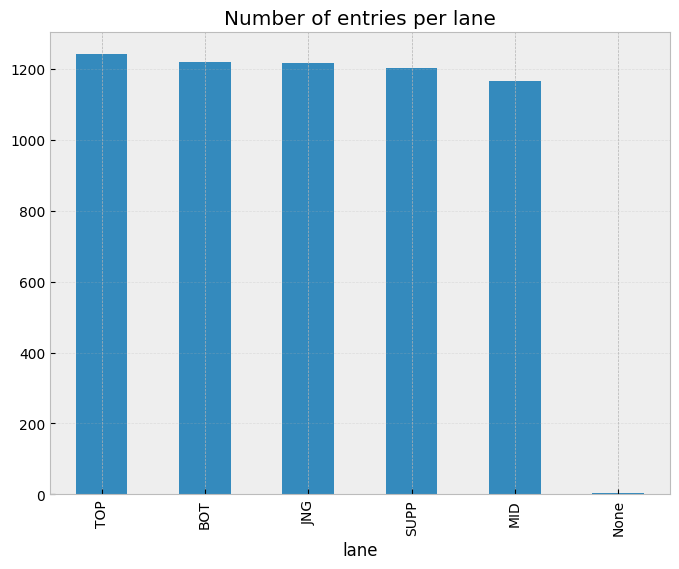

In [7]:
ax = data.value_counts('lane').plot(kind='bar', title='Number of entries per lane', figsize=(8,6))
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

The distribtion of lanes is balanced, as expected - in each game there is two players for each lane.

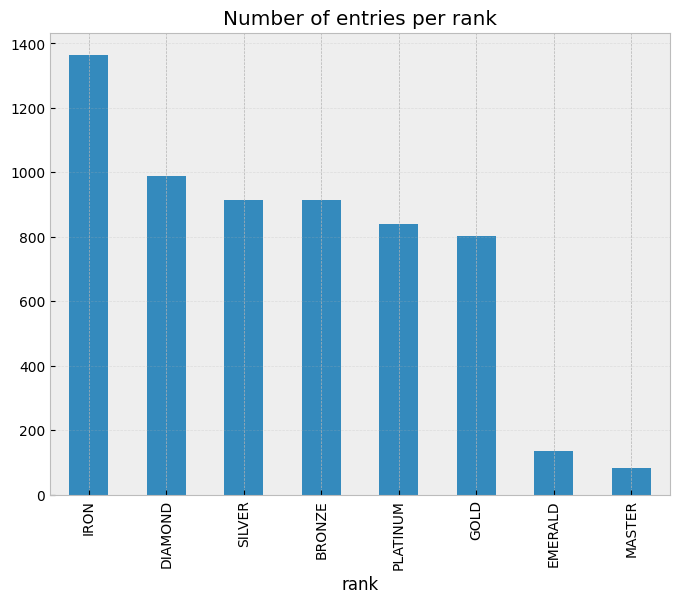

In [8]:
ax = data.value_counts('rank').plot(kind='bar', title='Number of entries per rank', figsize=(8,6))
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

Most of the entries are from the IRON rank, which is the lowest rank in the game. A lot of people getting new accounts start from there.

In [9]:
# some of the entries have lane as 'None' which is not a valid lane, so I will drop them
# also, I will drop the entries with rank as 'EMERALD' and 'MASTER' since there is not enough entries for this analysis
data = data[(data['lane'] != 'None') & ~(data['rank'].isin(["EMERALD", "MASTER"]))]

In [10]:
lane_groups = data.groupby('lane')

In [11]:
lane_groups.size()

lane
BOT     1180
JNG     1172
MID     1127
SUPP    1164
TOP     1177
dtype: int64

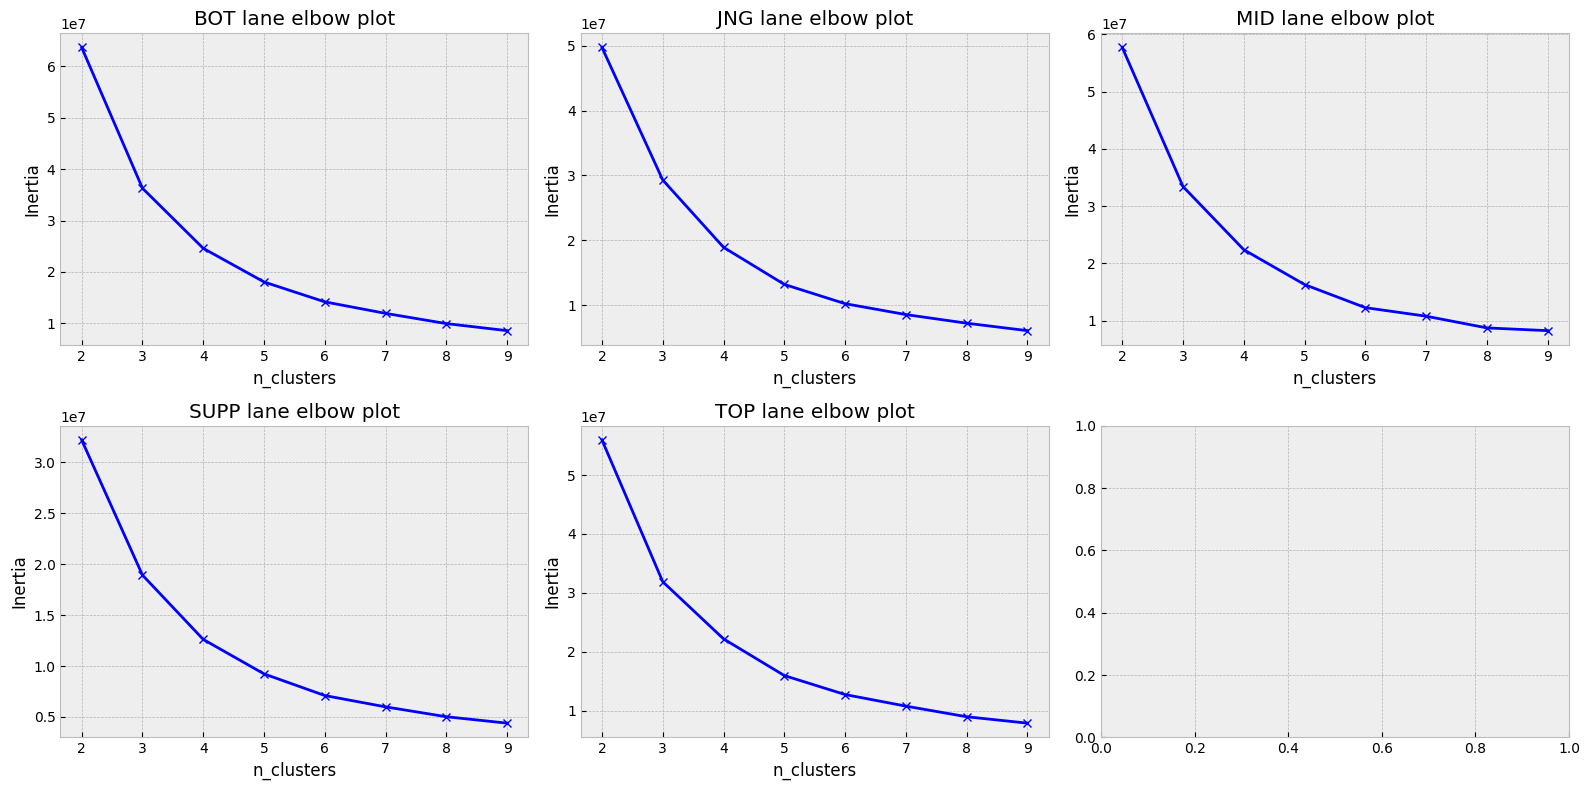

In [12]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(2, 3, figsize=(16,8))
for i, (lane, group) in enumerate(lane_groups):
    player_data = group.iloc[:, 0:4].values
    ranks = group.iloc[:, 4].values
    distortions = []
    K_el = range(2,10)
    for k_el in K_el:
        model = KMeans(n_clusters=k_el)
        model.fit(player_data)
        distortions.append(model.inertia_)
    ax[i//3, i%3].plot(K_el, distortions, 'bx-')
    ax[i//3, i%3].set_title(f'{lane} lane elbow plot')
    ax[i//3, i%3].set_xlabel('n_clusters')
    ax[i//3, i%3].set_ylabel('Inertia')

plt.tight_layout()
plt.show()

Three clusters seem to be the optimal number of clusters for all lanes. Let's fit the model with 3 clusters.

In [13]:
results = []
clustered_groups = []

for n, (lane, group) in enumerate(lane_groups):
    
    player_data = group.iloc[:, 0:4].values
    ranks = group.iloc[:, 4].values
    model = KMeans(n_clusters=3)
    model.fit(player_data)
    labels = model.labels_

    labels_divisions = pd.DataFrame(np.concatenate((ranks.reshape(-1,1), labels.reshape(-1,1)), axis=1), columns=['Rank', 'Cluster'])
    subset = labels_divisions.groupby(['Rank', 'Cluster']).size().reset_index(name='Counts')
    group['Cluster'] = labels
    clustered_groups.append((lane, group))
    results.append((lane, subset))


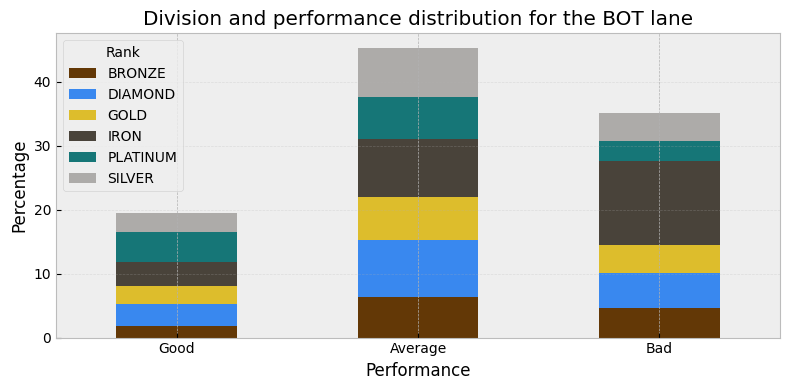

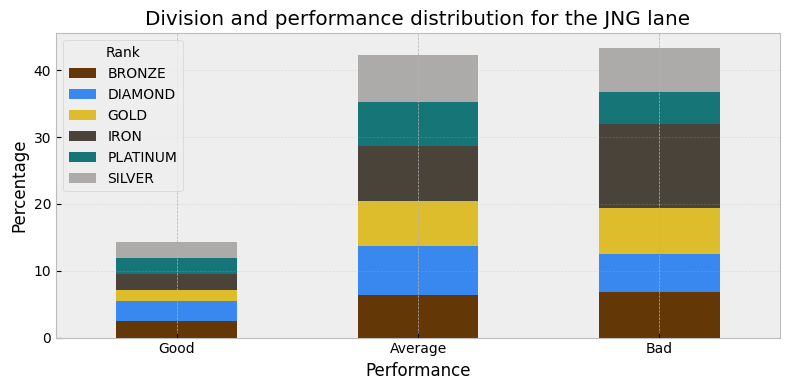

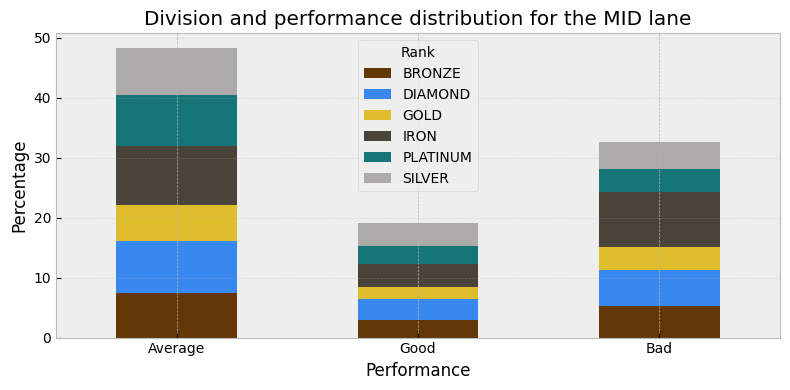

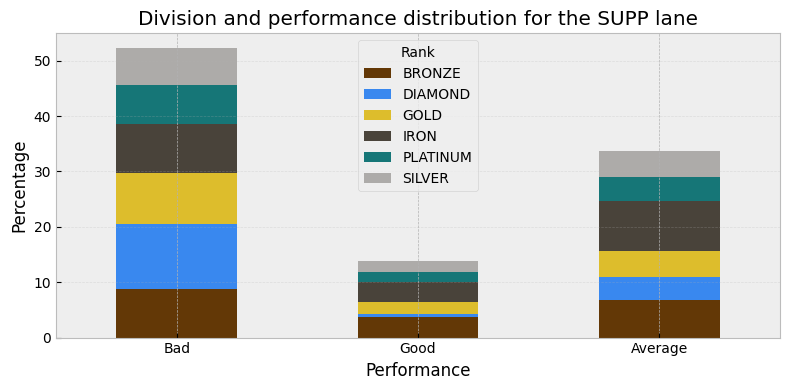

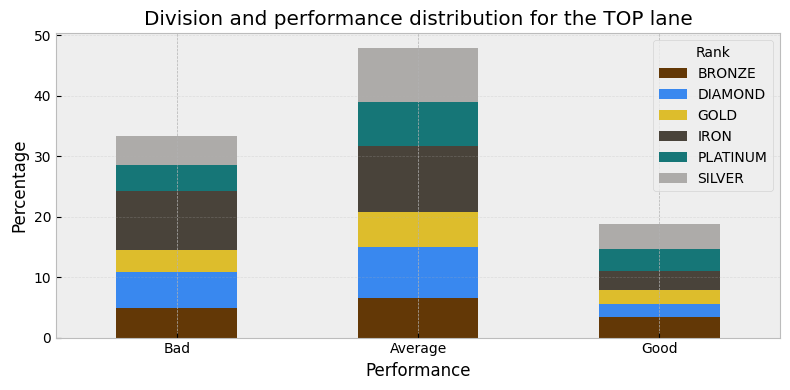

In [14]:
# lets look at the average values for each cluster
cluster_mappings = dict()
performance_groups = ["Good", "Average", "Bad"]
colors = ['#49433a', '#633806', '#adaba9', '#ddbd2c', '#167677', '#3988ef']
divisions = ['IRON', 'BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND']

color_dict = dict(zip(divisions, colors))

for lane, group in clustered_groups:
    by_cluster_means = group.groupby('Cluster').mean(numeric_only=True)
    by_cluster_means["Total"] = by_cluster_means.sum(axis=1)
    sorted_clusters = by_cluster_means.sort_values(by='Total', ascending=False)
    cluster_mappings[lane] = sorted(list(zip(sorted_clusters.index, performance_groups)), key=lambda x: x[0])


for lane, subset in results:
    total_entries = subset['Counts'].sum()
    subset['Percentage'] = subset.apply(lambda x: (x['Counts']/total_entries)*100, axis=1)
    pivot_table = subset.pivot(index='Cluster', columns='Rank', values='Percentage')
    ax = pivot_table.plot(kind='bar', stacked=True, color=color_dict, title=f'Division and performance distribution for the {lane} lane', figsize=(8,4))
    cluster_mapping = cluster_mappings[lane]
    cluster_label = [performance for _, performance in cluster_mapping]
    ax.set_xticklabels(cluster_label, rotation=0)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xlabel('Performance')
    ax.set_ylabel('Percentage')
    plt.tight_layout()
    plt.show()

#### Conclusions:
JNG and SUPP are the hardest lanes to perform well in, as there is significantly more bad performances in these lanes.
Division does not seem to differ a lot between the clusters.

#### Champions clustering

In [15]:
query = """SELECT c.champion_name, p.vision_score_per_min, p.dmg_per_min, p.gold_per_min,
           p.cs_per_min, p.kills, p.deaths, p.assists, p.dmg_taken_per_min, p.lane
           FROM player_data AS p LEFT JOIN champions as c ON c.champion_id=p.champion_id;"""

data = connection.execute_select_query(query)
data = pd.DataFrame(data)
data = data[data['lane'] != 'None']

data

,champion_name,vision_score_per_min,dmg_per_min,gold_per_min,cs_per_min,kills,deaths,assists,dmg_taken_per_min,lane
0,Karthus,0.753319,1956.870,523.637,1.049700,22,12,11,1350.890,JNG
1,Rammus,0.507208,702.903,388.191,0.381710,7,13,40,1400.950,JNG
2,Blitzcrank,2.859450,445.768,299.992,0.715706,4,10,33,1064.800,SUPP
3,Vayne,1.021830,1547.190,557.786,5.320080,24,8,13,1287.510,TOP
4,Leona,1.986760,624.430,283.096,0.954274,3,13,31,1232.830,SUPP
...,...,...,...,...,...,...,...,...,...,...
8455,Jhin,0.327506,224.907,287.173,4.469470,2,7,8,614.812,BOT
8456,Senna,1.925190,966.841,423.914,3.196190,10,9,6,848.185,SUPP
8457,Zed,0.819650,953.930,408.020,4.131660,10,11,10,935.548,MID
8458,Rakan,2.289710,214.914,302.049,1.091380,2,5,18,823.162,SUPP


In [16]:
data.isna().sum()

champion_name           0
vision_score_per_min    0
dmg_per_min             0
gold_per_min            0
cs_per_min              0
kills                   0
deaths                  0
assists                 0
dmg_taken_per_min       0
lane                    0
dtype: int64

In [17]:
champion_roles = data.groupby("champion_name")["lane"].value_counts(ascending=False)
champion_roles = pd.DataFrame(champion_roles.reset_index())

most_occurrences = []
for champion in champion_roles["champion_name"].unique():
    occurences_in_roles = champion_roles[champion_roles["champion_name"] == champion]
    most_popular_role = occurences_in_roles[occurences_in_roles["count"] == max(occurences_in_roles["count"])]
    most_occurrences.append((most_popular_role.iloc[0]["champion_name"], most_popular_role.iloc[0]["lane"]))
    
most_occurrences = pd.DataFrame(most_occurrences, columns=["champion_name", "lane"])
most_occurrences

,champion_name,lane
0,Aatrox,TOP
1,Ahri,MID
2,Akali,MID
3,Akshan,MID
4,Alistar,SUPP
...,...,...
162,Zeri,BOT
163,Ziggs,SUPP
164,Zilean,SUPP
165,Zoe,MID


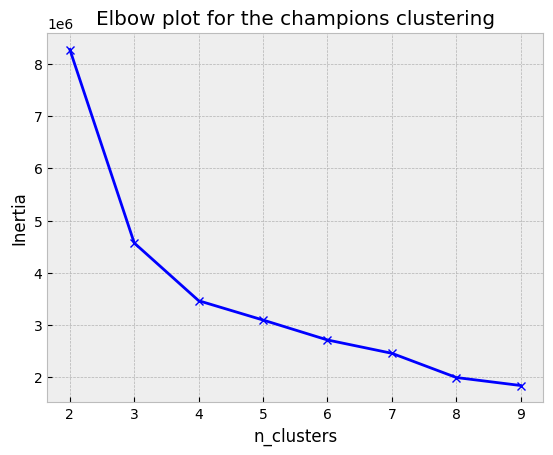

In [18]:
from sklearn.cluster import KMeans

clustering_columns = ['vision_score_per_min', 'dmg_per_min', 'gold_per_min', 'cs_per_min', 'dmg_taken_per_min', 'kills', 'deaths', 'assists']
target = "champion_name"
champion_groups = data.groupby(target).mean(numeric_only=True)
champion_groups.reset_index()
champion_groups = champion_groups.merge(most_occurrences, on="champion_name")
distortions = []

K_el = range(2,10)
for k_el in K_el:
    model = KMeans(n_clusters=k_el)
    X = champion_groups.loc[:, clustering_columns]
    model.fit(X)
    distortions.append(model.inertia_)

plt.title('Elbow plot for the champions clustering')
plt.xlabel('n_clusters')
plt.ylabel('Inertia')
plt.plot(K_el, distortions, 'bx-')
plt.show()

Based on the elbow plot above, I will choose 4 clusters for the champions clustering.

In [19]:
N_CLUSTERS = 4
model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
X = champion_groups.loc[:, clustering_columns]
model.fit(X)
champion_groups['Cluster'] = model.labels_

In [20]:
champion_groups

,champion_name,vision_score_per_min,dmg_per_min,gold_per_min,cs_per_min,kills,deaths,assists,dmg_taken_per_min,lane,Cluster
0,Aatrox,0.526949,773.806355,395.772903,6.147922,6.161290,5.838710,4.548387,1127.345581,TOP,1
1,Ahri,0.600985,755.856827,384.342780,5.811741,6.330000,5.970000,7.630000,741.845487,MID,3
2,Akali,0.546145,732.052437,386.303417,5.315985,8.093750,5.666667,4.531250,877.930648,MID,0
3,Akshan,0.519203,838.887368,443.508875,6.175953,8.875000,5.350000,4.325000,740.500670,MID,3
4,Alistar,2.053656,266.287923,276.689591,0.771067,1.636364,6.363636,13.863636,868.832227,SUPP,2
...,...,...,...,...,...,...,...,...,...,...,...
162,Zeri,0.571727,714.391459,426.938568,6.633591,7.351351,5.864865,6.108108,750.797297,BOT,3
163,Ziggs,0.926662,948.337850,412.263650,5.069716,6.550000,6.350000,7.850000,629.450750,SUPP,3
164,Zilean,1.650204,344.516000,281.111727,1.308649,1.909091,6.636364,11.454545,835.034182,SUPP,2
165,Zoe,0.906280,738.926692,384.250462,4.740779,6.769231,4.307692,7.153846,551.342385,MID,3


In [21]:
champ_cluster = champion_groups[["champion_name", "Cluster"]].values
champ_cluster = {pair[0] : pair[1] for pair in champ_cluster}

data["Cluster"] = data["champion_name"].infer_objects(copy=False).replace(champ_cluster)
data

/var/folders/p5/5h0hmqdn3qn_zqtvdbyg_nfm0000gn/T/ipykernel_14833/3106676642.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Cluster"] = data["champion_name"].infer_objects(copy=False).replace(champ_cluster)


,champion_name,vision_score_per_min,dmg_per_min,gold_per_min,cs_per_min,kills,deaths,assists,dmg_taken_per_min,lane,Cluster
0,Karthus,0.753319,1956.870,523.637,1.049700,22,12,11,1350.890,JNG,0
1,Rammus,0.507208,702.903,388.191,0.381710,7,13,40,1400.950,JNG,0
2,Blitzcrank,2.859450,445.768,299.992,0.715706,4,10,33,1064.800,SUPP,2
3,Vayne,1.021830,1547.190,557.786,5.320080,24,8,13,1287.510,TOP,3
4,Leona,1.986760,624.430,283.096,0.954274,3,13,31,1232.830,SUPP,2
...,...,...,...,...,...,...,...,...,...,...,...
8455,Jhin,0.327506,224.907,287.173,4.469470,2,7,8,614.812,BOT,3
8456,Senna,1.925190,966.841,423.914,3.196190,10,9,6,848.185,SUPP,3
8457,Zed,0.819650,953.930,408.020,4.131660,10,11,10,935.548,MID,3
8458,Rakan,2.289710,214.914,302.049,1.091380,2,5,18,823.162,SUPP,2


What are the most popular champions in each cluster? And what defines the clusters?

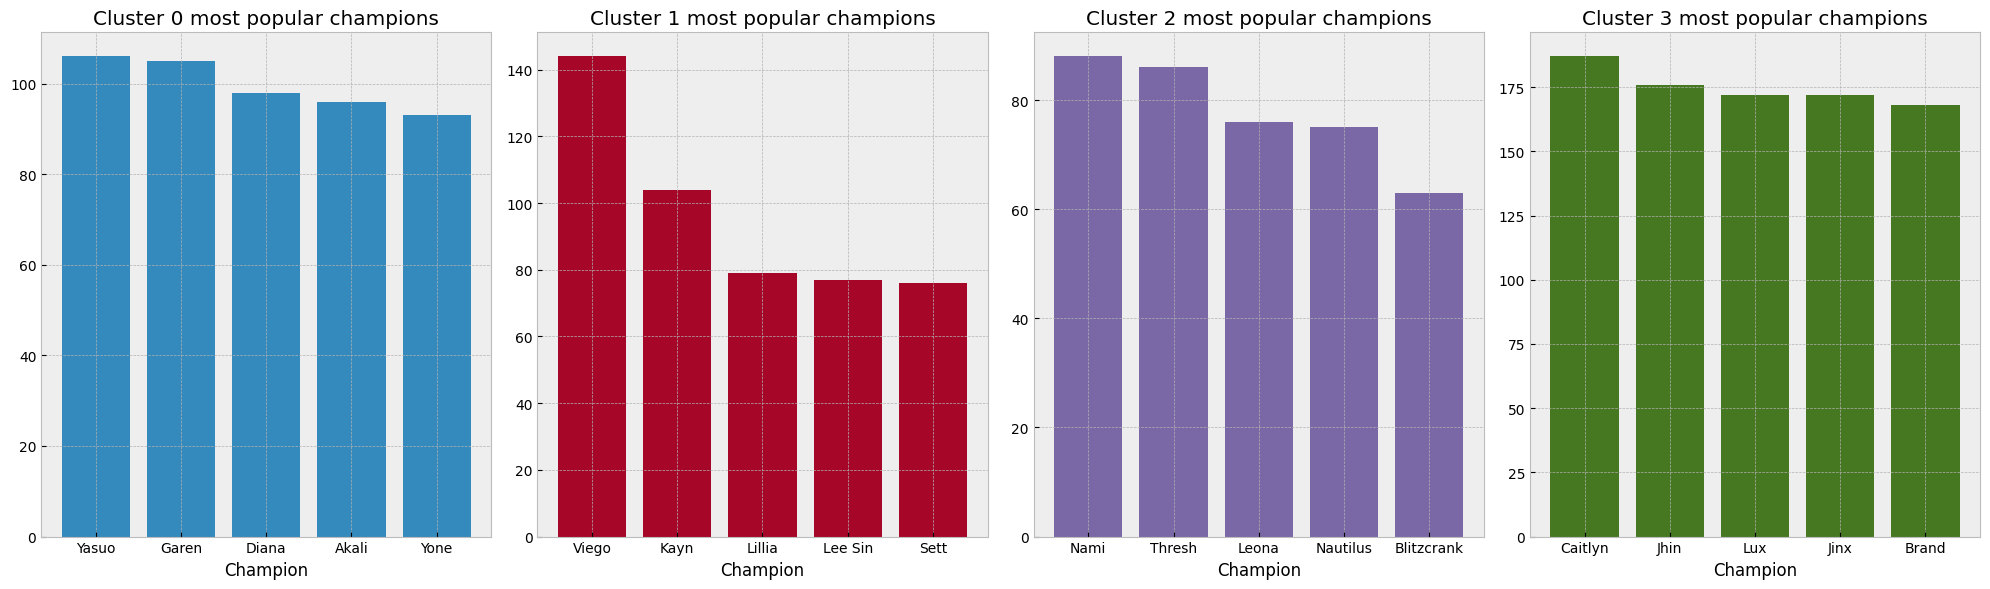

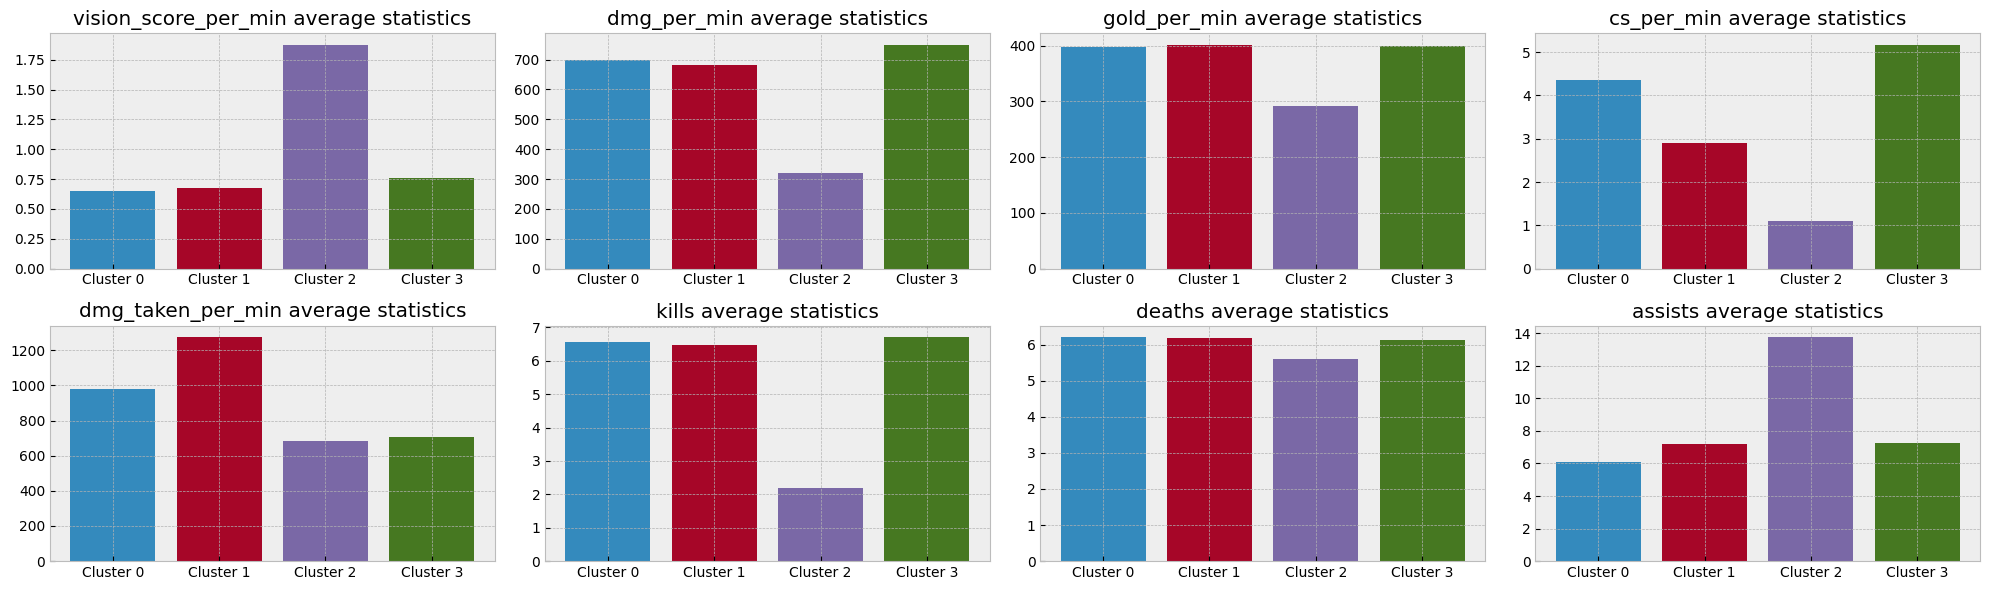

In [22]:
from itertools import cycle
import matplotlib

colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']

champion_groups_clusters = data.groupby('Cluster')
fig, ax = plt.subplots(1, N_CLUSTERS, figsize=(20,6))
group_means = champion_groups_clusters.mean(numeric_only=True)
cluster_means = []
color_cycle = cycle(colors)


for i, (cluster, group) in enumerate(champion_groups_clusters):
    popular_champions = group['champion_name'].value_counts().head(5)
    ax[i].bar(popular_champions.index, popular_champions.values, color=next(color_cycle))
    ax[i].set_title(f'Cluster {cluster} most popular champions')
    ax[i].set_xlabel('Champion')
    cluster_means.append(group.mean(numeric_only=True))
    
plt.tight_layout()
plt.show()
 
n_columns = len(clustering_columns) // 2
fig, ax = plt.subplots(2, n_columns, figsize=(20,6))
   
for i, column in enumerate(clustering_columns):
    column_data = []
    
    for cluster in cluster_means:
        column_data.append(cluster[column])
    ax[i // n_columns , i % n_columns].bar([f"Cluster {i}" for i in range(N_CLUSTERS)], column_data, color=colors)
    ax[i // n_columns, i % n_columns].set_title(f'{column} average statistics')

plt.tight_layout()
plt.show()

#### Conclusions:
- Cluster 0 - Melee champions, bruisers
- Cluster 1 - Most damage taken, frontline bruisers / tanks
- Cluster 2 - Supports
- Cluster 3 - Offensive champions (Marksmen and high damage mages) 


Let's now try to cluster champions within the same lane

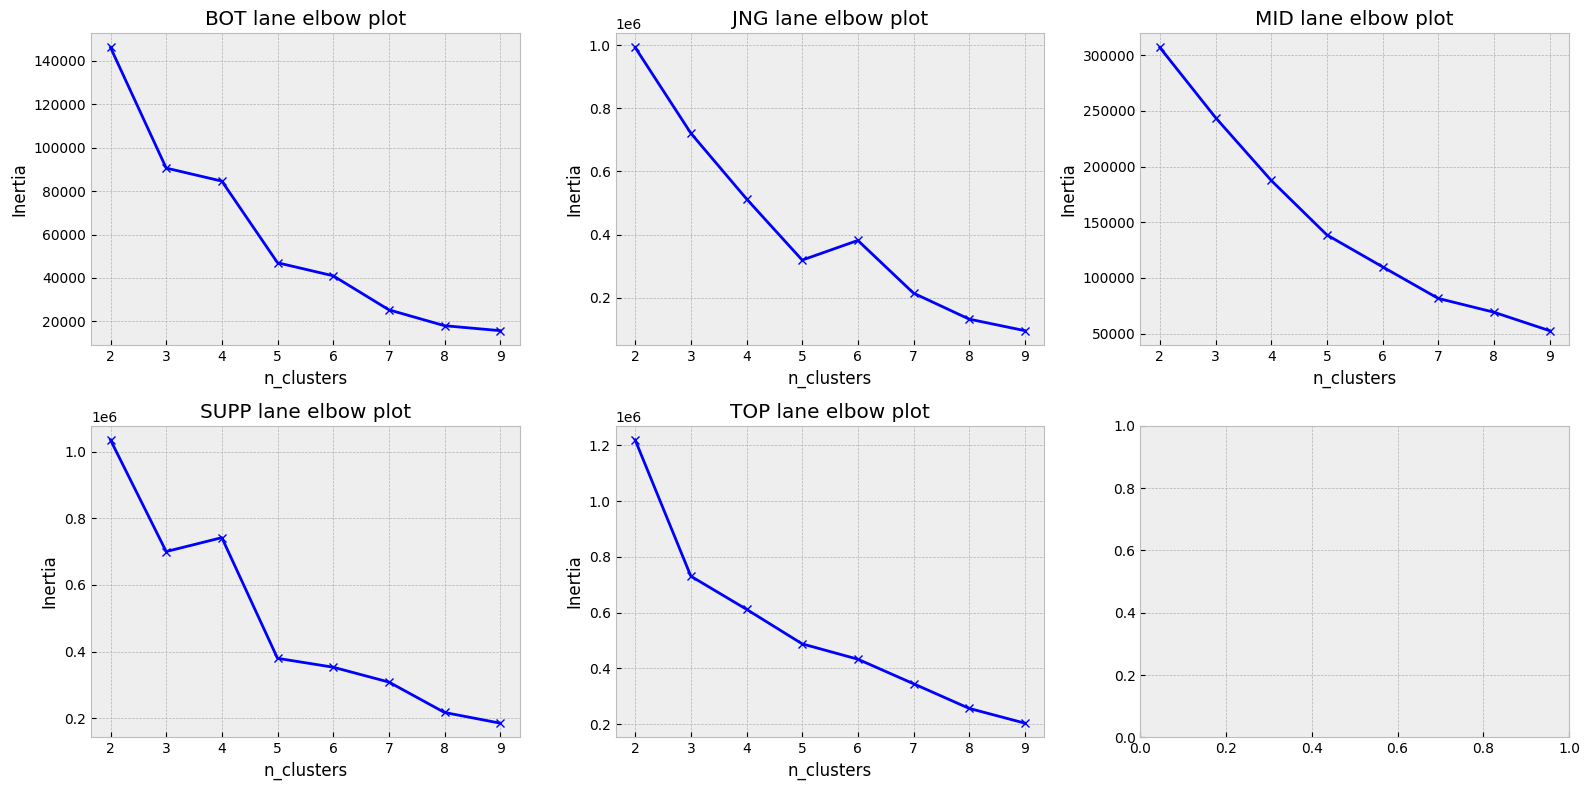

In [23]:
lane_champ_groups = champion_groups.groupby('lane')

clustering_columns = ['vision_score_per_min', 'dmg_per_min', 'gold_per_min', 'cs_per_min', 'dmg_taken_per_min']
distortions = []

fig, ax = plt.subplots(2, 3, figsize=(16,8))
for i, (lane, group) in enumerate(lane_champ_groups):
    player_data = group.loc[:, clustering_columns].values
    distortions = []
    K_el = range(2,10)
    for k_el in K_el:
        model = KMeans(n_clusters=k_el)
        model.fit(player_data)
        distortions.append(model.inertia_)
    ax[i//3, i%3].plot(K_el, distortions, 'bx-')
    ax[i//3, i%3].set_title(f'{lane} lane elbow plot')
    ax[i//3, i%3].set_xlabel('n_clusters')
    ax[i//3, i%3].set_ylabel('Inertia')

plt.tight_layout()
plt.show()

#### Based on the elbow plot above, the number of clusters for each lane is:
- Top lane - 5 clusters
- Jungle lane - 4 clusters
- Support lane 4 clusters
- Middle lane - 4 clusters
- Bottom lane - 3 clusters

In [24]:
def plot_clusters_by_lane(lane, n_clusters, df, champion_groups):
    data = df[df['lane'] == lane].copy()
    
    clustering_columns = ['vision_score_per_min', 'dmg_per_min', 'gold_per_min', 'cs_per_min', 'dmg_taken_per_min', 'kills', 'deaths', 'assists']
    champion_groups_lane = champion_groups[champion_groups["lane"] == lane].copy()
    model = KMeans(n_clusters=n_clusters, random_state=42)
    X = champion_groups_lane.loc[:, clustering_columns]
    model.fit(X)
    champion_groups_lane["Cluster"] = model.labels_
    
    champ_cluster = champion_groups_lane[["champion_name", "Cluster"]].values
    champ_cluster = {pair[0] : pair[1] for pair in champ_cluster}
    
    data["Cluster"] = data["champion_name"].replace(champ_cluster)
    # removing nonstandard laners from the data
    data = data[data["Cluster"].isin(champion_groups_lane["Cluster"].unique())]
    
    fig, ax = plt.subplots(1, n_clusters, figsize=(20,8))
    cluster_means = []

    colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
    color_cycle = cycle(colors)
    champion_groups_clusters = data.groupby('Cluster')

    for i, (cluster, group) in enumerate(champion_groups_clusters):
        popular_champions = group['champion_name'].value_counts().head(5)
        ax[i].bar(popular_champions.index, popular_champions.values, color=next(color_cycle))
        ax[i].set_title(f'Cluster {cluster} most popular champions')
        ax[i].set_xticks(ticks=ax[i].get_xticks())
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)

        ax[i].set_xlabel('Champion')
        cluster_means.append(group.mean(numeric_only=True))

    plt.tight_layout()
    plt.show()

    n_columns = len(clustering_columns) // 2
    fig, ax = plt.subplots(2, n_columns, figsize=(20,6))

    for i, column in enumerate(clustering_columns):
        column_data = []
        for cluster in cluster_means:
            column_data.append(cluster[column])
        ax[i // n_columns , i % n_columns].bar([f"Cluster {i}" for i in range(n_clusters)], column_data, color=colors)
        ax[i // n_columns, i % n_columns].set_title(f'{column} average statistics')

    plt.tight_layout()
    plt.show()

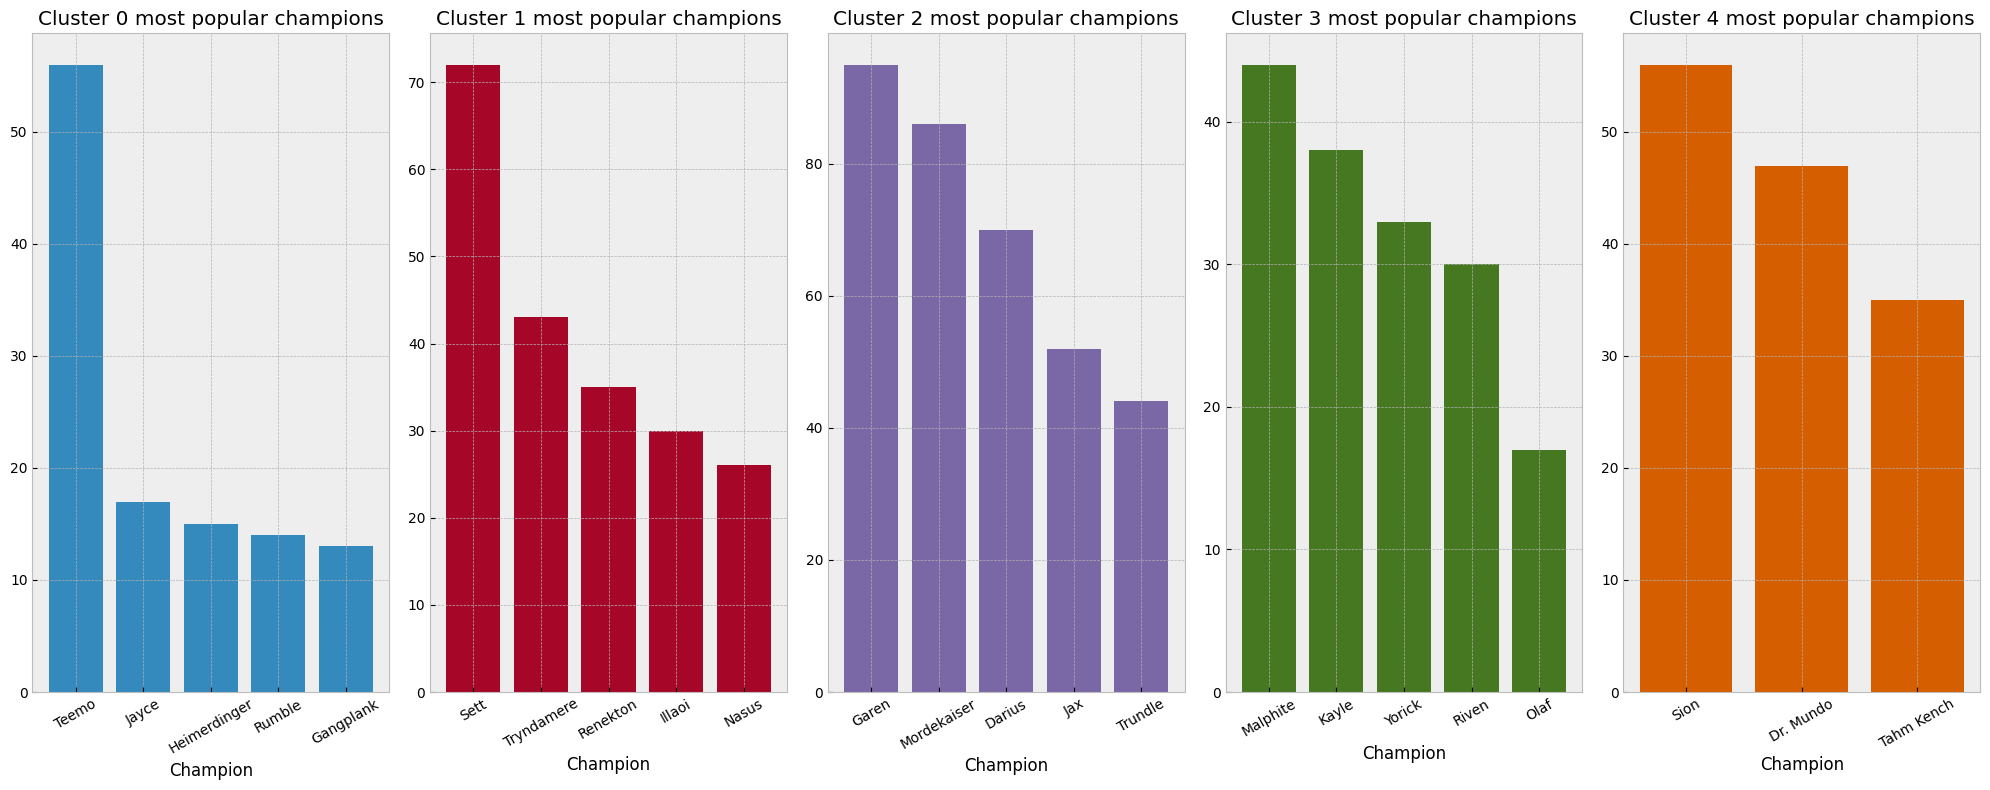

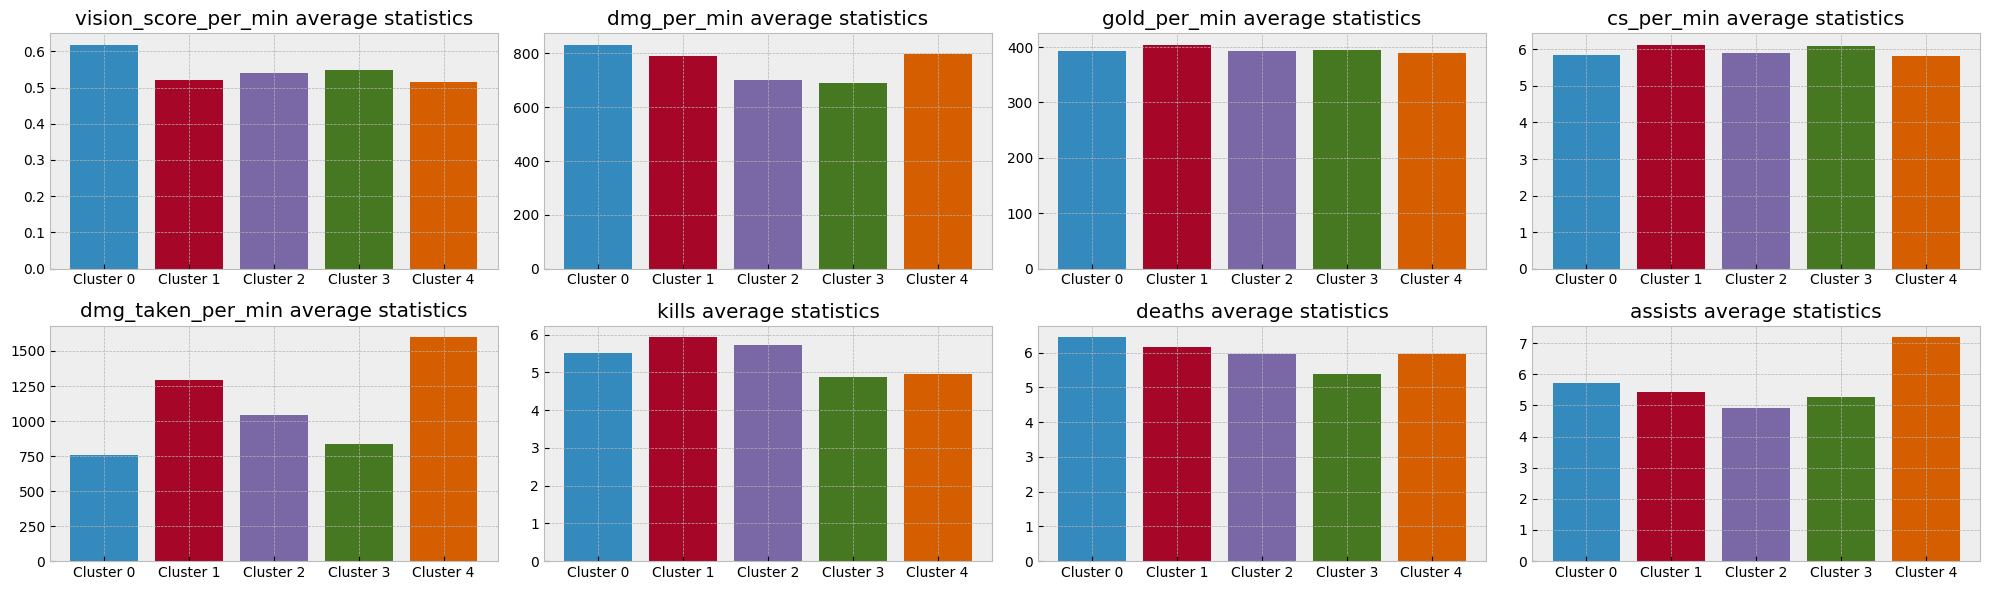

In [25]:
plot_clusters_by_lane('TOP', 5, data, champion_groups) 

Divided mostly by damage taken per minute
#### Conclusions:
- Cluster 0 - Range / high damage champions
- Cluster 1 and 3 - Mostly has bruisers, but the red cluster ones seem to have more dmg/min taken 
- Cluster 2 - Low 
- Cluster 4 - Tanks

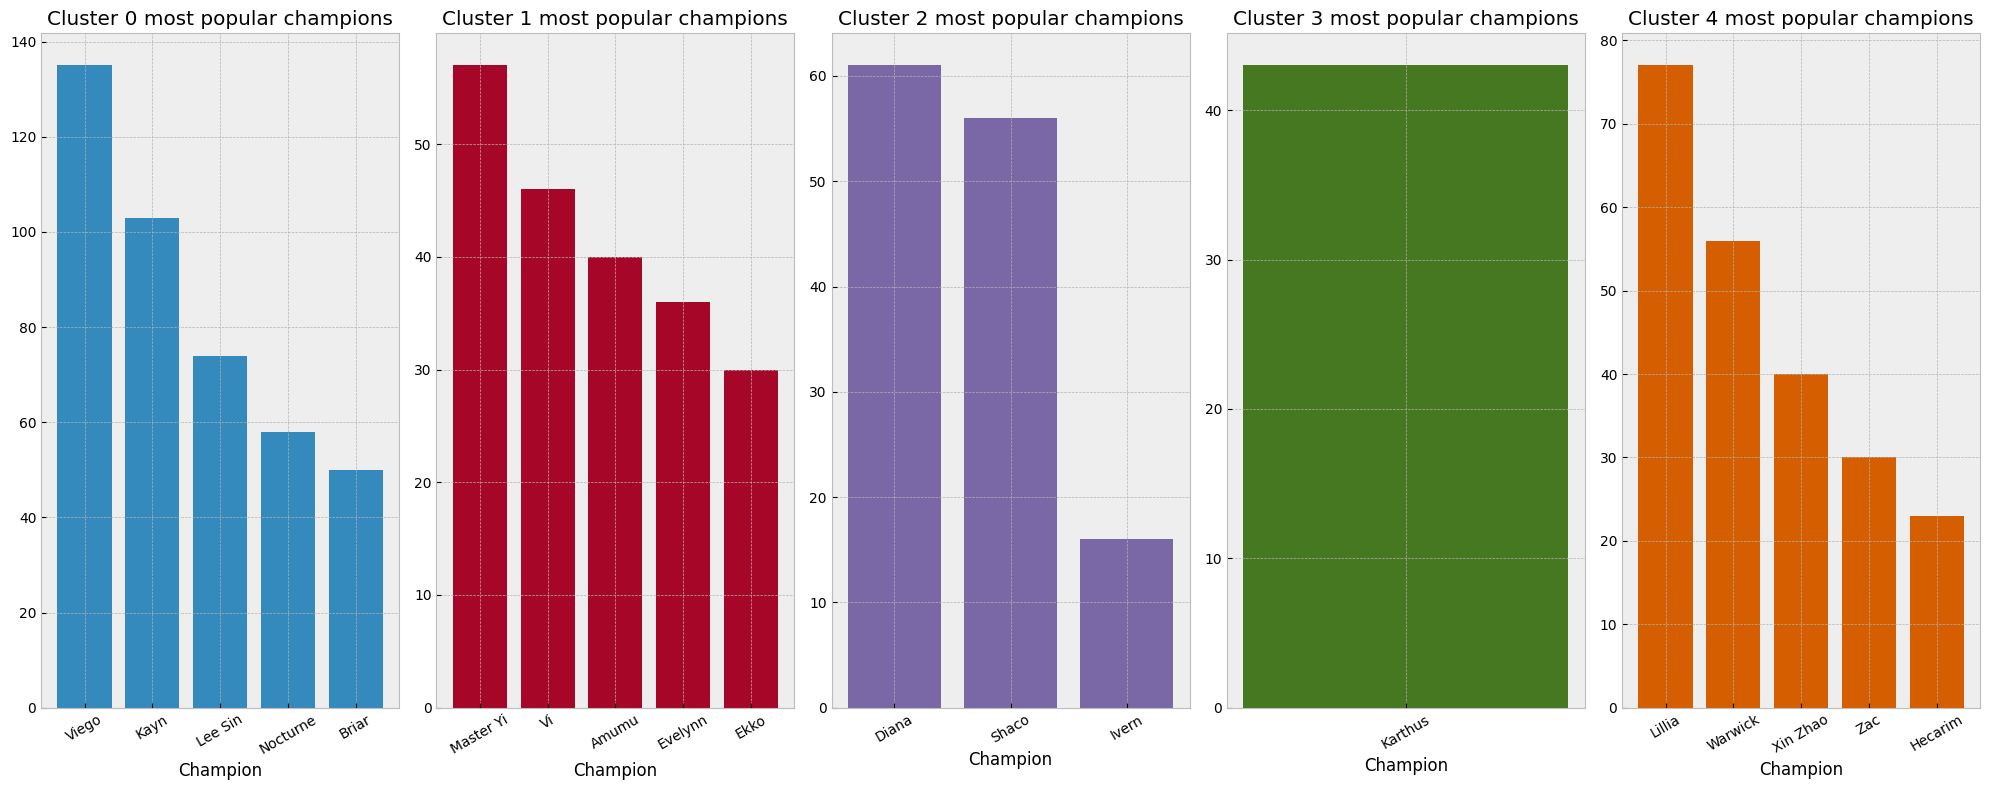

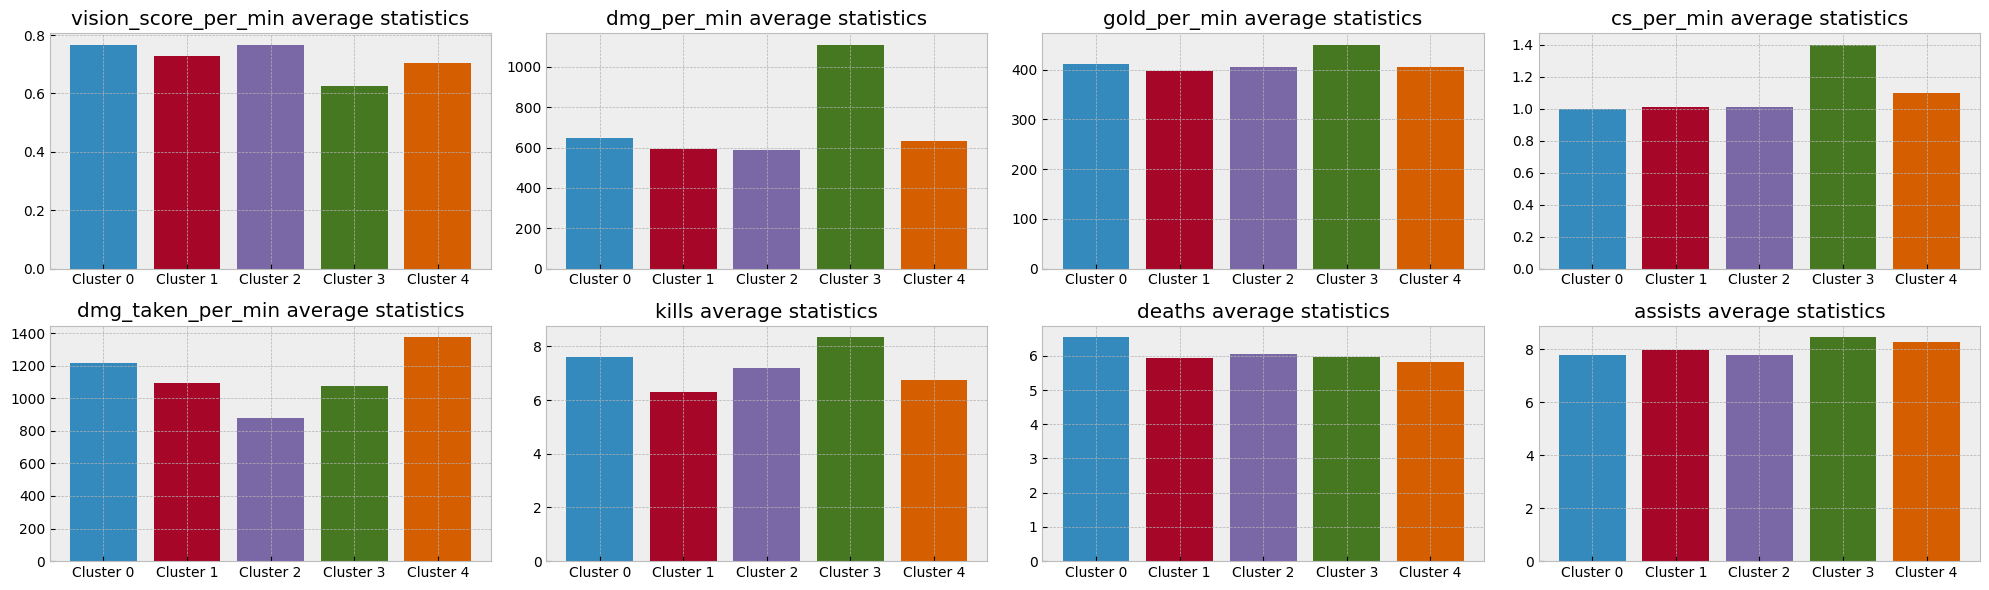

In [26]:
plot_clusters_by_lane('JNG', 5, data, champion_groups) 

#### Conclusions: 
Only conclusion I can make that clustering says that karthus has a specific playstyle, but other clusters are not informative. They are mostly divided by the amount of damage dealt and taken. Cluster 4 has frontline champions - they are grouped probably because of damage taken

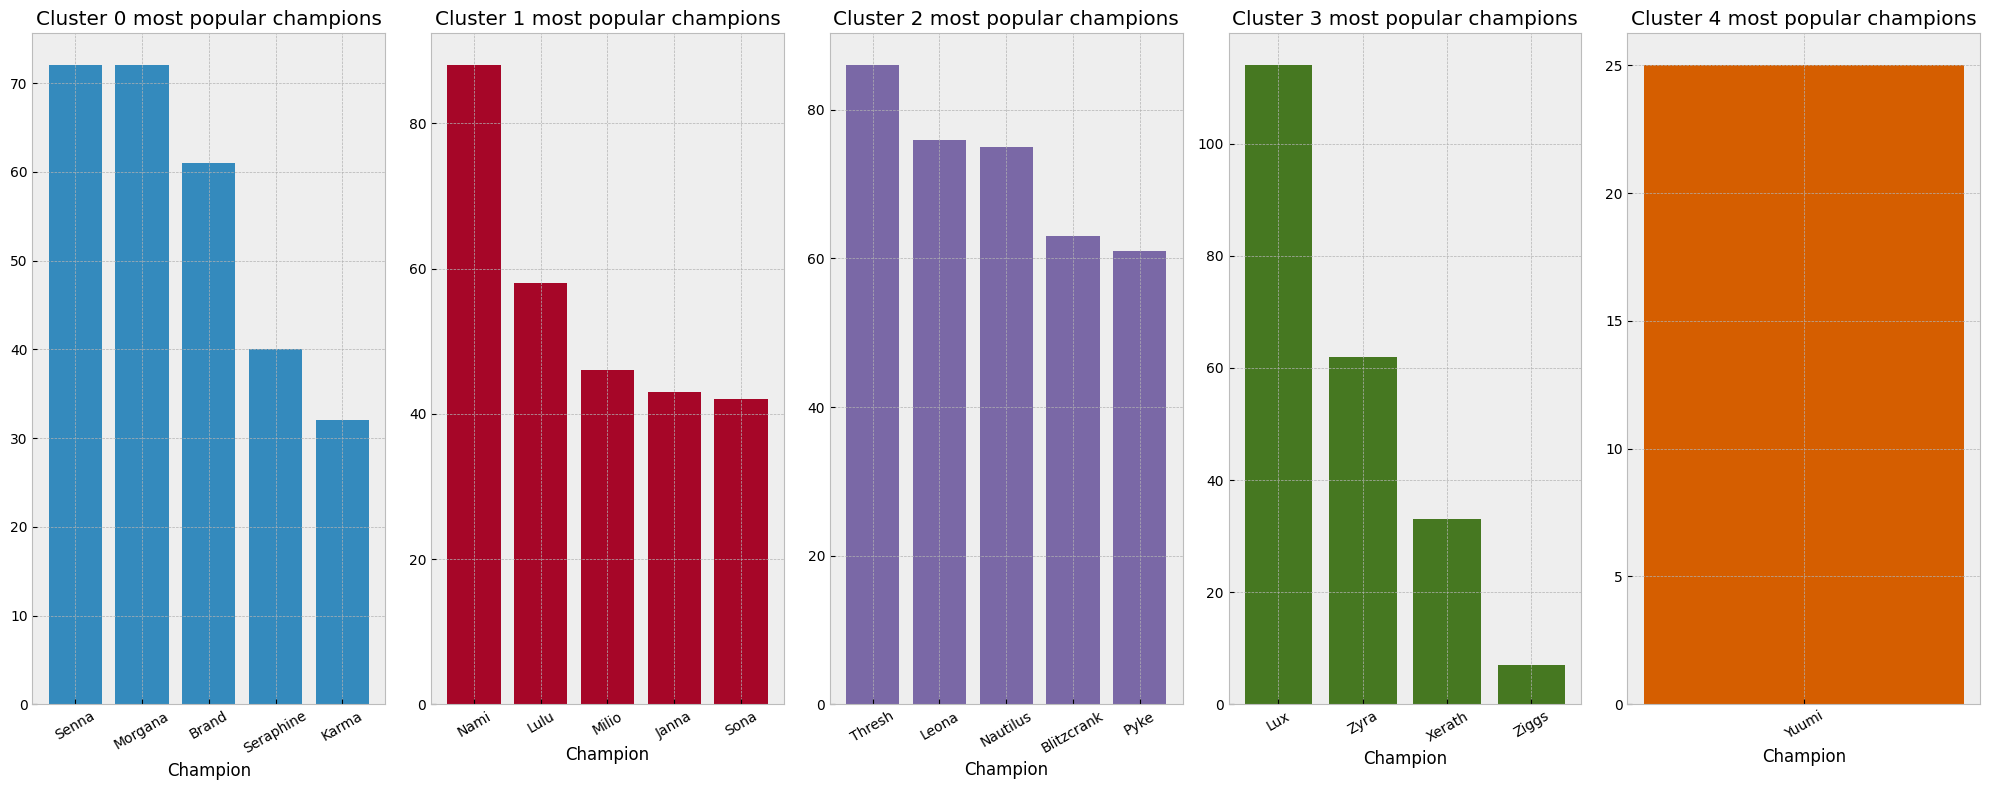

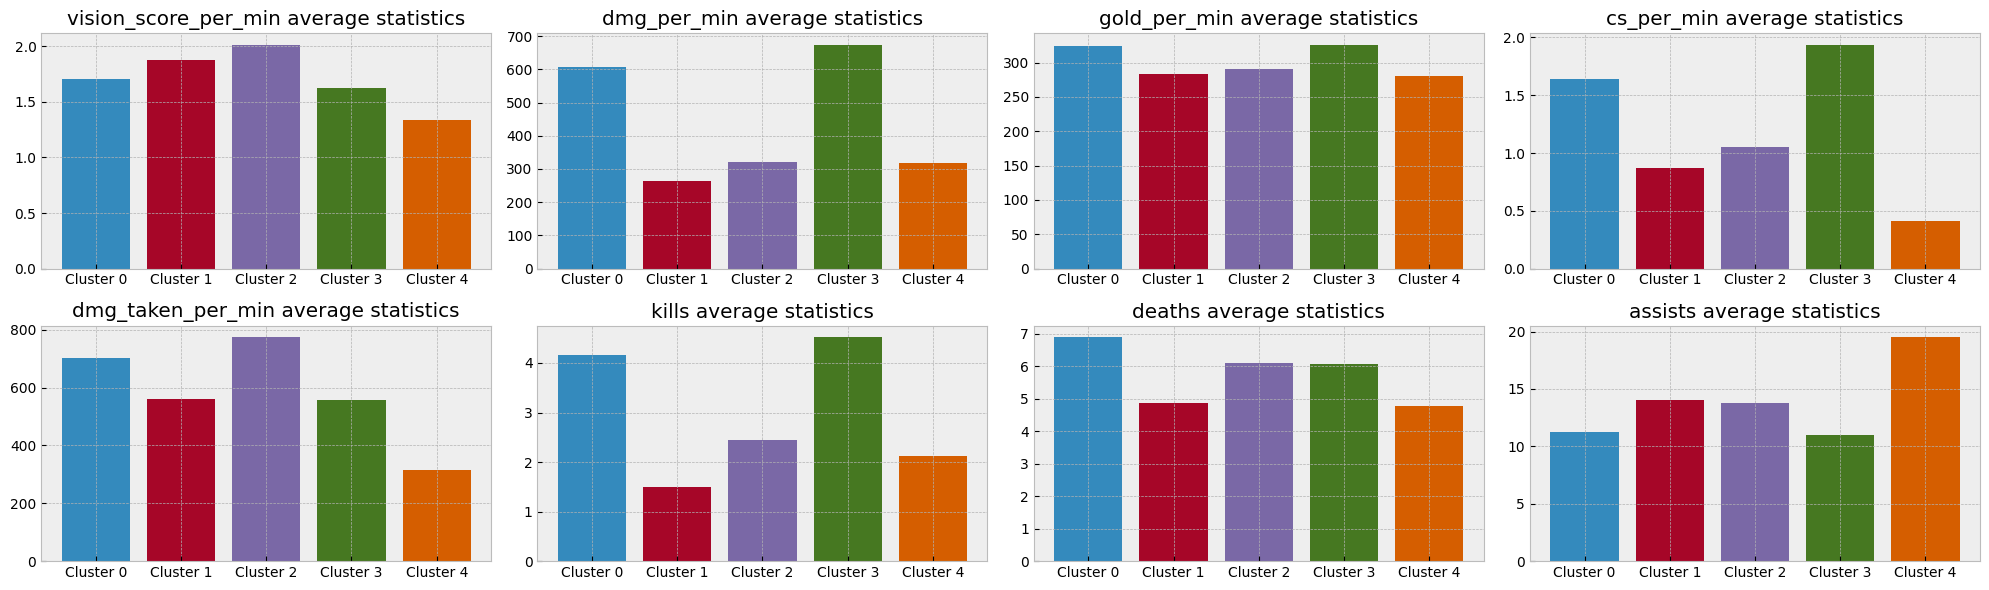

In [27]:
plot_clusters_by_lane('SUPP', 5, data, champion_groups) 

#### Conclusions:
- Cluster 0 - Damage supports
- Cluster 1 - Enchanter supports
- Cluster 2 - Tank supports
- Cluster 3 - Mage supports, simillar to cluster 0 but higher range - less damage taken, a bit more cs
- Cluster 4 - Yuumi - very specific playstyle - takes and deals very little damage 

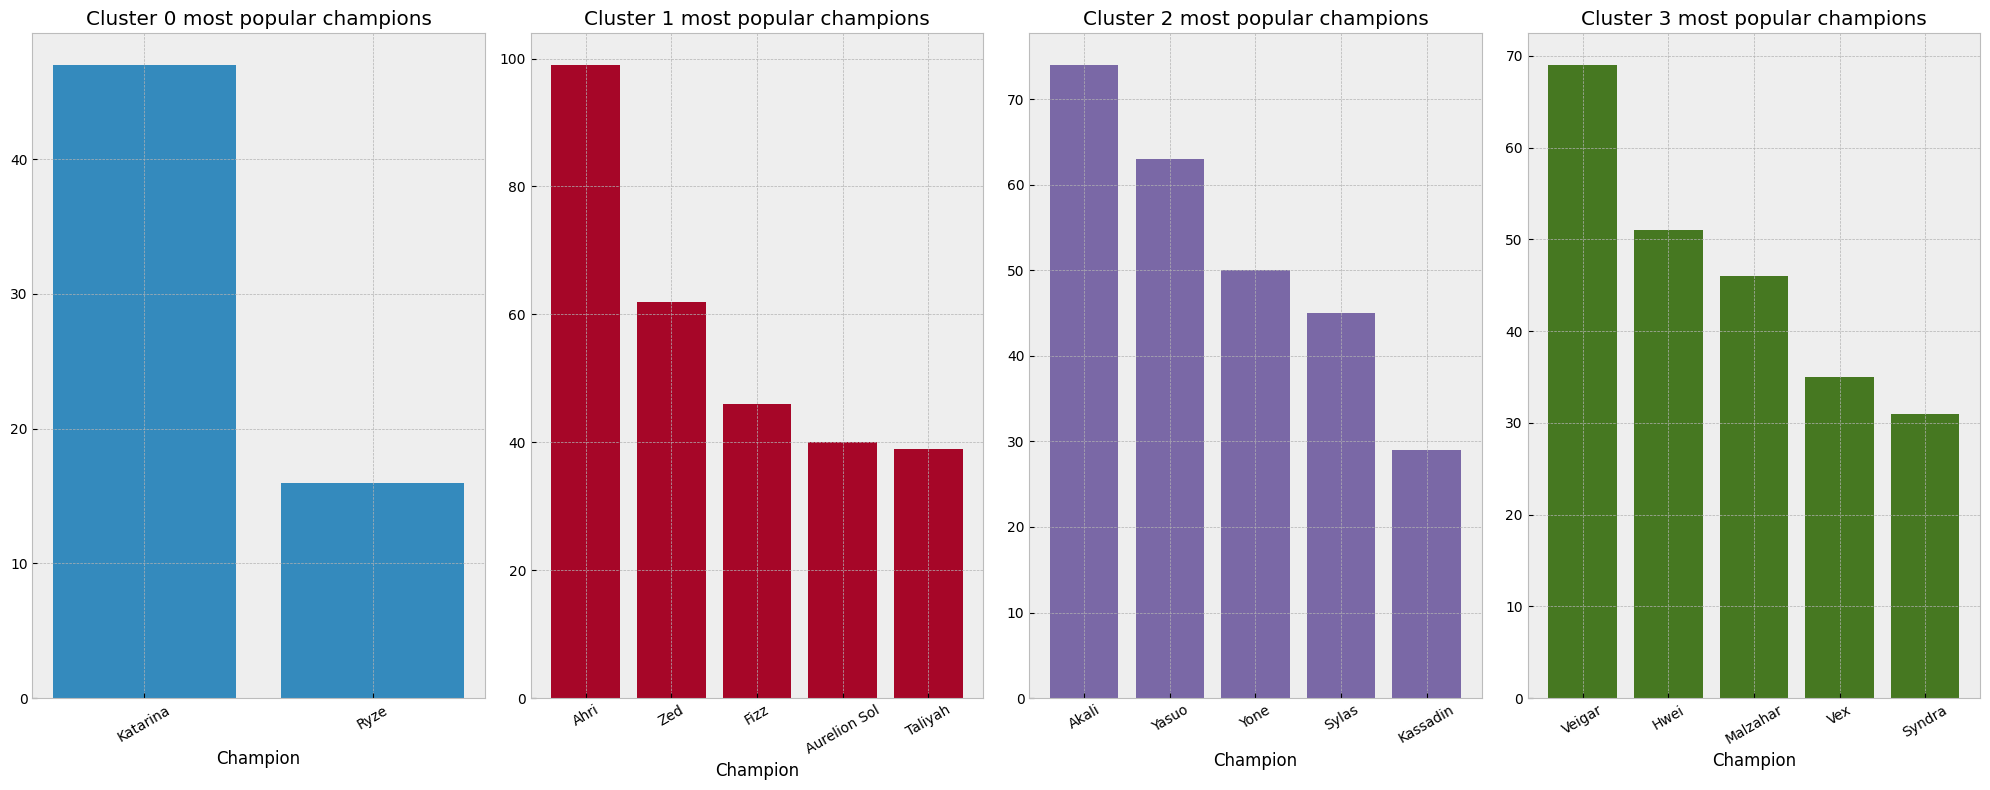

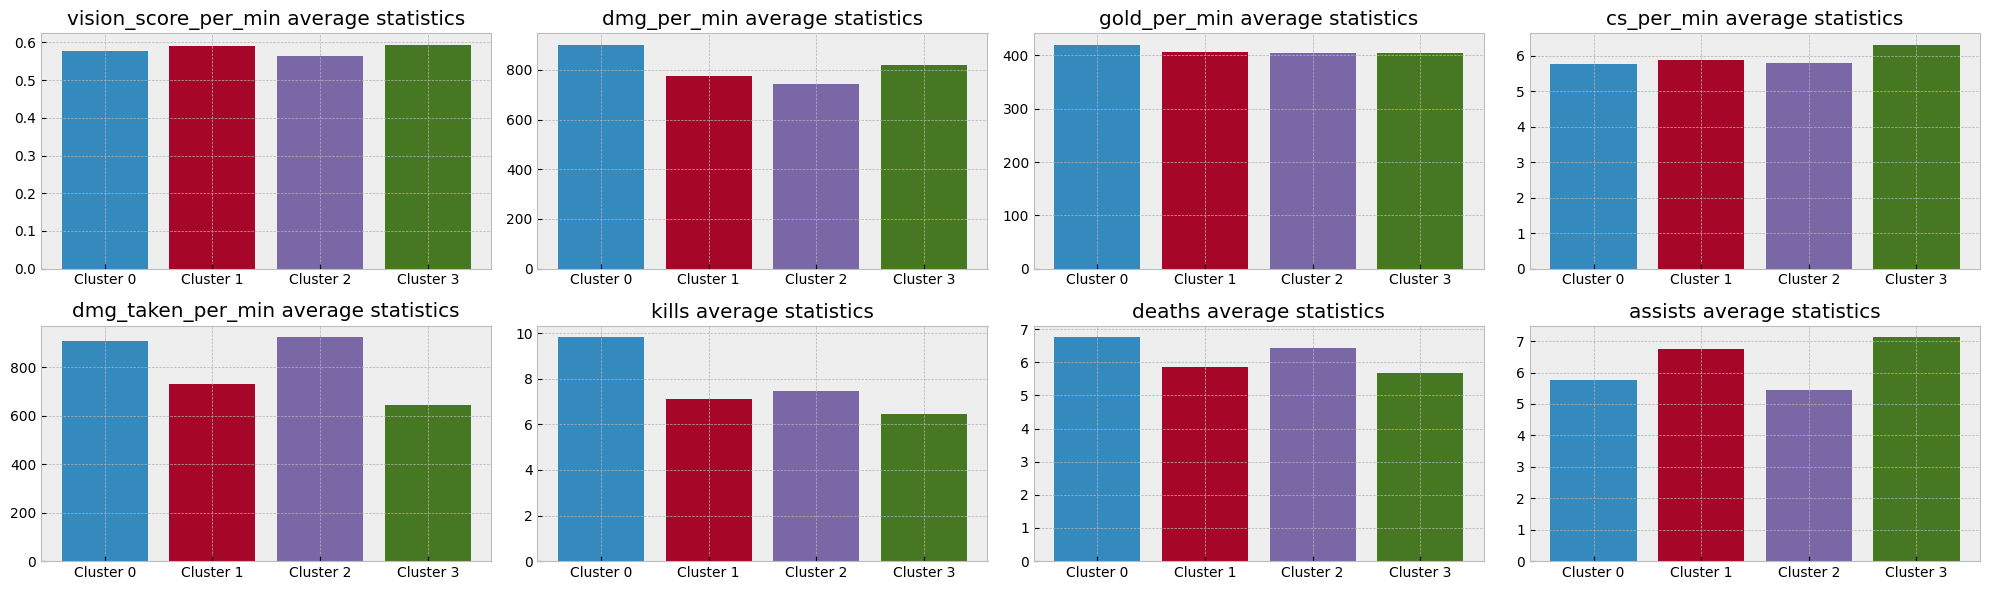

In [28]:
plot_clusters_by_lane('MID', 4, data, champion_groups)

#### Conclusions:
- Cluster 0 - Probably exists as these champions are played mostly by people who play them a lot an perform better overall because of more experience
- Cluster 1 - Does not group any specific group of champions
- Cluster 2 - Assasins
- Cluster 3 - Mages

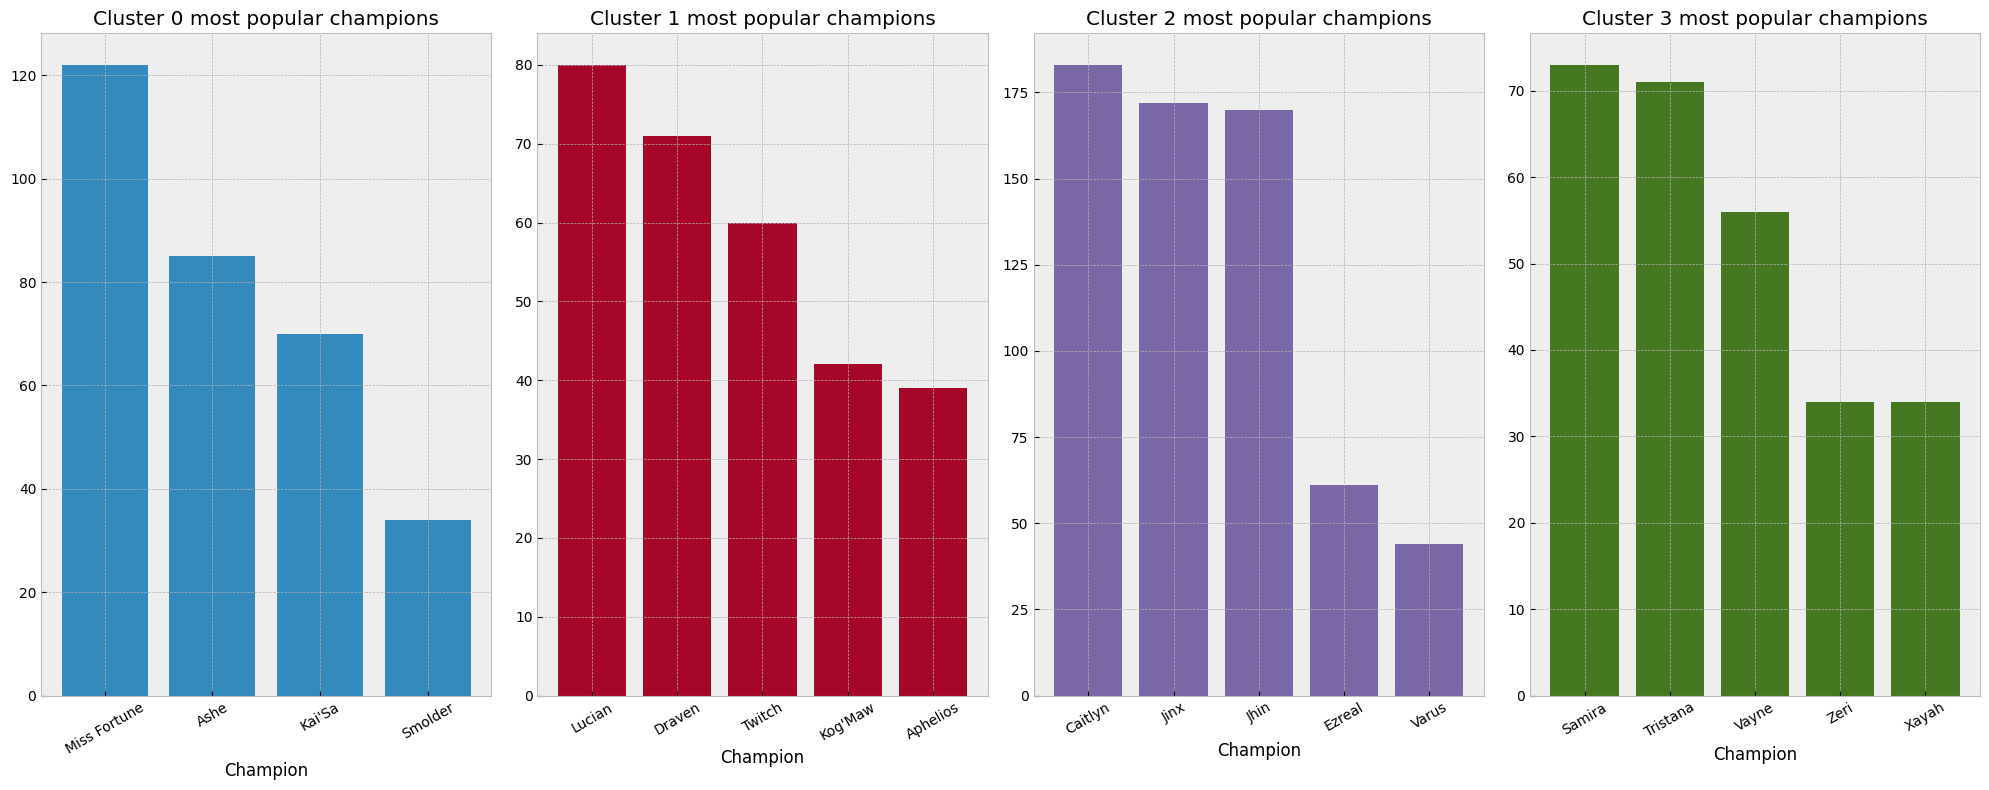

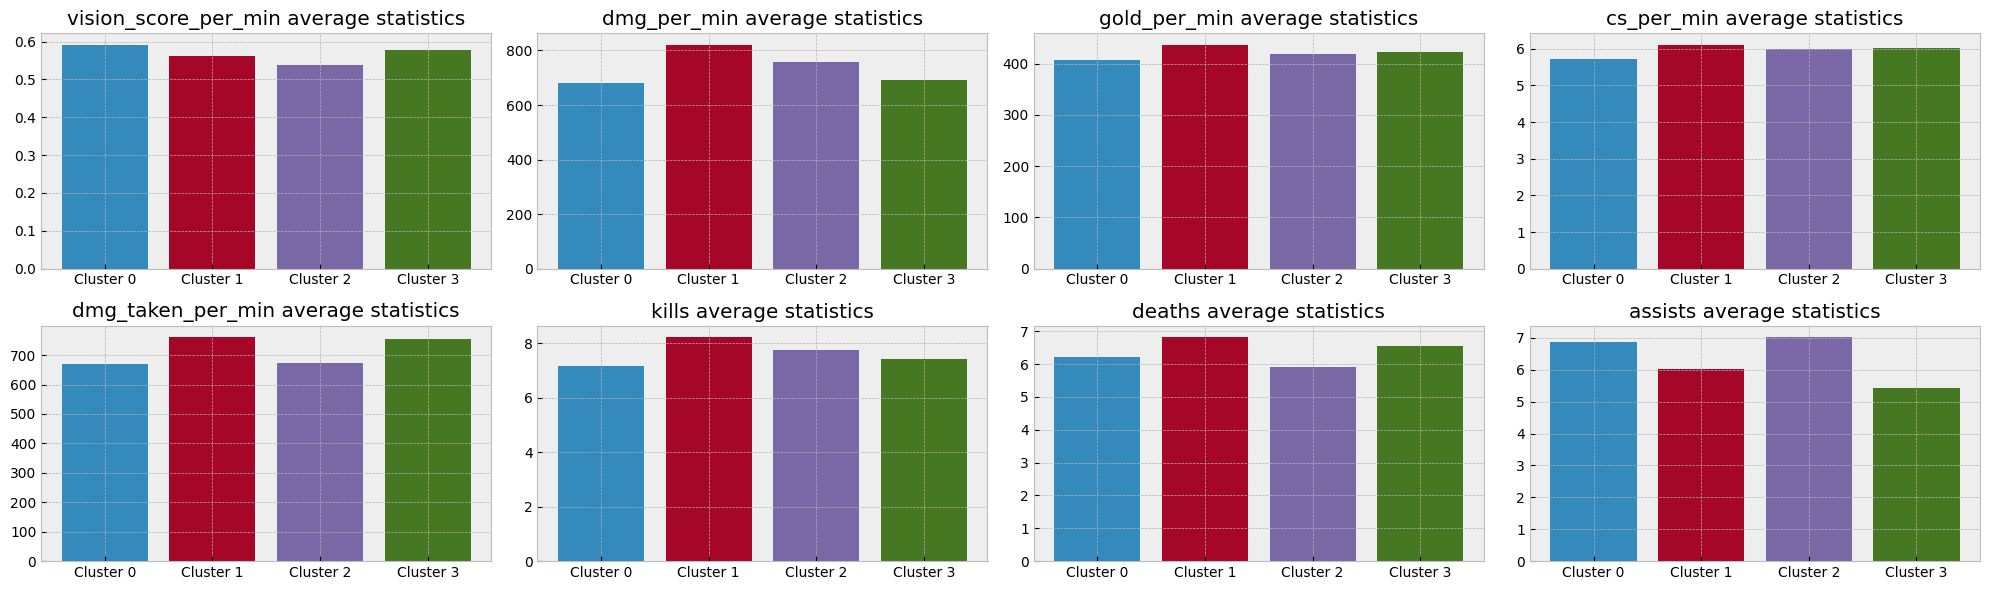

In [29]:
plot_clusters_by_lane('BOT', 4, data, champion_groups)

#### Conclusions:
It is hard to cluster champions in the BOT lane as all of them are marksmen and have similar playstyle.